# Prediction using COVID-GRAM

Calculate COVID-GRAM score

[Source of variables](https://www.mdcalc.com/calc/10303/covid-gram-critical-illness-risk-score#evidence)

Original variables
1. X-ray abnormality (y/n)
2. Age, years (float)
3. Hemoptysis (y/n)
4. Dyspnea (y/n)
5. Unconsciousness (y/n)
6. Number of comorbidities (float) (Includes COPD, hypertension, diabetes, coronary heart disease, chronic heart disease, chronic kidney disease, cancer, cerebral vascular disease, Hepatitis B, and immunodeficiency)
7. Cancer history (y/n)
8. Neutrophil to lymphocyte ration (float)
9. Lactate dehydrogenase, U/L (float)
10. Direct bilirubin, µmol/L (float)

Our variable names
1. `xray_admission_pathological_n/y`
2. `age`
3. `cough_type` == "k"
4. `a_feeling_of_difficulty_breathing_n/y`
5. `other_problems_write` == "kolaps" / "kolapsi"
6. approximated by adding: `cd_lungs_n/y` + `arterial_hypertension_n/y` + `diabetes_n/y` + `heart_failure_n/y` + `cd_kidney_n/y` + `hiv_n/y` + `active_mlg_disease_n/y` + `chronic_disease_other_write`
7. `chronic_disease_other_write` == "ca - Ca - CA"  / "tumorji" / "*carcinoma"
8. approximated by: `neutrophils` / `lymphocyte_admission` 
9. `ldh_admission_µkat/L`
10. `total_bilirubin_admission_µmol/L`

In [1]:
import os 
import numpy as np 
import pandas as pd

In [2]:
data = pd.read_csv("/home/skatz/PROJECTS/covid/disease_severity/data/10_data_cleaned.csv")

## Get COVID-GRAM score

In [3]:
dic_points = {"y":1, 
              "y, gs":1,
              "n":0,
              np.nan:0}

''' 1. X-ray abnormality (y/n)'''
data["gramScore_xray"] = data["xray_admission_pathological_n/y"].replace(dic_points)

''' 2. age'''
data["gramScore_age"] = data["age"]

''' 3. Hemoptysis'''
idx = data[data["cough_type"].str.contains("k", na=False)].index
data["gramScore_hemoptysis"] = 0
data.loc[idx,"gramScore_hemoptysis"] = 1

''' 4. Dyspnea'''
data["gramScore_dyspnea"] = data["a_feeling_of_difficulty_breathing_n/y"].replace(dic_points)

''' 5. Unconsciousness (y/n)'''
idx = data[data["other_problems_write"].str.contains("kolaps*", na=False)].index
data["gramScore_unconsciousness"] = 0
data.loc[idx,"gramScore_unconsciousness"] = 1


''' 7. cancer history'''
idx = data[data["chronic_disease_other_write"].str.contains("ca |tumorji|karcinom", na=False, regex=True, case=False)].index
data["gramScore_cancer"] = 0
data.loc[idx,"gramScore_cancer"] = 1


''' 8. Neutrophil to lymphocyte ration (float) '''
data["gramScore_neutroLymphoRation"] = data["neutrophils"]/data["lymphocyte_admission"]


''' 9. LDH (U/L); conversion factor: 0.01667; 1 U/L = 0.01667 µkat/L '''
data["gramScore_ldh"] = data["ldh_admission_µkat/L"]/0.01667


''' 10. Direct bilirubin, µmol/L '''
data["gramScore_bilirubin"] = data["total_bilirubin_admission_µmol/L"]


''' 6. Number of comorbidities '''
data["chronic_disease_other_write"][(data["chronic_disease_other_write"] != np.nan) & (data["chronic_disease_other_write"] != "n")] = "y"
comorbs = ["cd_lungs_n/y","arterial_hypertension_n/y","diabetes_n/y","heart_failure_n/y","cd_kidney_n/y","hiv_n/y","active_mlg_disease_n/y","chronic_disease_other_write"]
data["gramScore_comorbidities"] = data.loc[:,comorbs].replace(dic_points).sum(axis=1)

/tmp/ipykernel_3379341/1032357417.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["chronic_disease_other_write"][(data["chronic_disease_other_write"] != np.nan) & (data["chronic_disease_other_write"] != "n")] = "y"


In [4]:
data.iloc[-1,-11:]

disease_severity                       4.0
gramScore_xray                         1.0
gramScore_age                         39.0
gramScore_hemoptysis                     0
gramScore_dyspnea                      1.0
gramScore_unconsciousness                0
gramScore_cancer                         0
gramScore_neutroLymphoRation      9.470588
gramScore_ldh                   662.267546
gramScore_bilirubin                    7.0
gramScore_comorbidities                0.0
Name: 192, dtype: object

## Calculate disease severity probability

Risk of critical illness* (%) = ex / (1 + ex)

Where 
x = 
(X-ray abnormality x 1.2205) + 
(Age x 0.0276) + 
(Hemoptysis  x 1.5116) + 
(Dyspnea x 0.632) + 
(Unconsciousness x 1.5494) + 
(Number of comorbidities x 0.4668) + 
(Cancer history x 1.4037) + 
(Neutrophil to lymphocyte ratio x 0.0562) + 
(Lactate dehydrogenase x 0.0024) + 
(Direct bilirubin x 0.1376) 
- 6.6127


*Defined by admission to the intensive care unit (ICU), invasive ventilation, or death.

In [5]:
data.loc[:,data.columns.str.contains("sample_id|gramScore|disease_severity", regex=True)]

,sample_id,disease_severity,gramScore_xray,gramScore_age,gramScore_hemoptysis,gramScore_dyspnea,gramScore_unconsciousness,gramScore_cancer,gramScore_neutroLymphoRation,gramScore_ldh,gramScore_bilirubin,gramScore_comorbidities
0,CVD-0001,3.0,1.0,49.000000,0,1.0,0,0,3.611111,286.142771,12.0,3.0
1,CVD-0002,3.0,1.0,52.000000,0,1.0,0,0,2.800000,NaN,NaN,0.0
2,CVD-0003,3.0,1.0,67.000000,0,0.0,0,0,5.444444,345.530894,11.0,1.0
3,CVD-0004,2.0,1.0,83.000000,0,1.0,0,0,2.846154,233.353329,10.0,4.0
4,CVD-0005,3.0,1.0,34.617385,0,1.0,0,0,4.454545,503.299340,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
188,CVD-0206,2.0,1.0,63.000000,0,1.0,0,0,3.691489,301.739652,9.0,0.0
189,CVD-0209,3.0,1.0,54.000000,0,0.0,0,0,12.750000,319.736053,7.0,0.0
190,CVD-0217,2.0,1.0,45.000000,0,1.0,0,0,1.796992,211.757648,7.0,2.0
191,CVD-0219,2.0,1.0,47.000000,1,1.0,0,0,3.507463,319.136173,8.0,0.0


In [6]:
df_gram = data.loc[:,data.columns.str.contains("sample_id|gramScore|disease_severity", regex=True)].copy()  #"sample_id|gramScore|disease_severity"

### Drop patients without full annoations
df_gram = df_gram.dropna(axis=0)

### Multiply each column with coefficients
df_gram["gramScore_xray"] = df_gram["gramScore_xray"]*1.2205
df_gram["gramScore_age"] = df_gram["gramScore_age"]*0.0276
df_gram["gramScore_hemoptysis"] = df_gram["gramScore_hemoptysis"]*1.5116
df_gram["gramScore_dyspnea"] = df_gram["gramScore_dyspnea"]*0.632
df_gram["gramScore_unconsciousness"] = df_gram["gramScore_unconsciousness"]*1.5494
df_gram["gramScore_comorbidities"] = df_gram["gramScore_comorbidities"]*0.4668
df_gram["gramScore_cancer"] = df_gram["gramScore_cancer"]*1.4037
df_gram["gramScore_neutroLymphoRation"] = df_gram["gramScore_neutroLymphoRation"]*0.0562
df_gram["gramScore_ldh"] = df_gram["gramScore_ldh"]*0.0024
df_gram["gramScore_bilirubin"] = df_gram["gramScore_bilirubin"]*0.1376

### Sum up & subtract constant (- 6.6127)
df_gram["x_prior"] = df_gram.iloc[:,2:].sum(axis=1) - 6.6127

### Calculate probability
def gramProba(x):
    return np.exp(x) / (1 + np.exp(x))
df_gram["gramScore_probability"] = df_gram["x_prior"].map(gramProba)

df_gram[["sample_id","disease_severity","gramScore_probability"]]

,sample_id,disease_severity,gramScore_probability
0,CVD-0001,3.0,0.630296
2,CVD-0003,3.0,0.394760
3,CVD-0004,2.0,0.816648
4,CVD-0005,3.0,0.357255
5,CVD-0007,2.0,0.026923
...,...,...,...
188,CVD-0206,2.0,0.299147
189,CVD-0209,3.0,0.189282
190,CVD-0217,2.0,0.266551
191,CVD-0219,2.0,0.528082


1.0    126
0.0     29
Name: disease_severity, dtype: int64

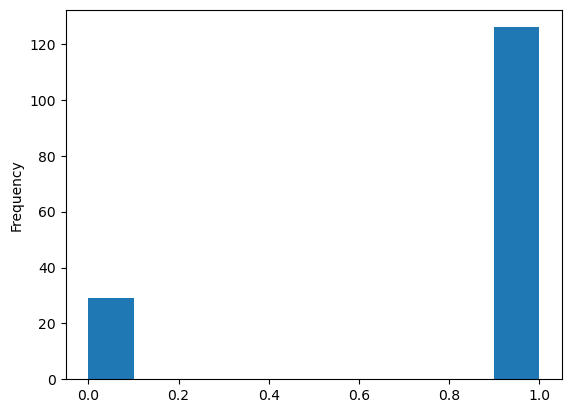

In [7]:
''' 
Only save patients overlapping with our DiscoveryValidation cohort (164 patients) & add correct disease severity score
'''
df_discoveryVal = pd.read_csv("../../results/preprocessing/cleaned/12_hospitalization_disease_severity_cleaned.csv")
df_discoveryVal.index = df_discoveryVal["sample_id"]
ids_overlap = list(set(df_discoveryVal["sample_id"]) & set(df_gram["sample_id"]))

''' Only parse overlapping patients & add encoded disease severity score '''
df_gram.index = df_gram["sample_id"]
df_gram = df_gram.loc[ids_overlap,:]
df_gram["disease_severity"] = df_discoveryVal["disease_severity"]

''' For interest: disease severity distribtuion with this subset?'''
df_gram.loc[:, "disease_severity"].plot.hist()
df_gram.loc[:, "disease_severity"].value_counts()

In [8]:
''' save in file for plotting '''
PATH_out = f"../../results/prediction/COVID_GRAM"
os.makedirs(PATH_out, exist_ok=True)

df_gram[["sample_id","disease_severity","gramScore_probability"]].to_csv(f"{PATH_out}/covid_gram_probas.csv", index=False)